In [2]:
import numpy as np
import random
from numpy.linalg import*
import matplotlib.pyplot as plt
from numpy import r_, exp, cos, sin, pi, zeros, ones, hanning, sqrt, log, floor, reshape, mean
from scipy import signal
from numpy.fft import fft
import math
import time
import scipy.optimize as opt

import scipy.io as sio
import scipy.io.wavfile
import sounddevice as sd
from IPython.display import Audio

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import copy
%matplotlib inline
#import Functions_201116
#from Functions_201116 import *

In [5]:
def Tshift(arr,tau,fs):
    num = int(tau*fs)
    arr=np.roll(arr,num)
    if num<0:
         np.put(arr,range(len(arr)+num,len(arr)),0)
    elif num > 0:
         np.put(arr,range(num),0)
    return arr

def Tshift_Ups(arr,tau,fs,factor):
    arr_ups = signal.resample(arr, len(arr)*factor)
    fs_ups = fs*factor
    num = int(tau*fs_ups)
    arr_ups=np.roll(arr_ups,num)
    if num<0:
         np.put(arr_ups,range(len(arr_ups)+num,len(arr_ups)),0)
    elif num > 0:
         np.put(arr_ups,range(num),0)
            
    arr_ups_LPF = butter_lowpass_filter(arr_ups, fs, fs_ups, 10)
            
    return arr_ups_LPF[::factor]

def ArrayVec_deg_WB(N,Angle_deg, freq, vp):
    phi = 2*np.pi*freq*d*math.sin(Angle_deg*np.pi/180)/vp
    a=[]
    for i in range(N):
        a.append(math.e**(i*-1j*phi))
    return np.asarray(a)

def deg2ind(deg_list):              #Convert angle in degree to index of Angle_Sweep   Updated on 15th Nov. 2020
    if type(deg_list) != list:
        deg_list = np.array([deg_list])
    index_list = np.array([])
    for deg in deg_list:
        index_list = np.append(index_list, (N_Angle-1)*(deg-theta_start)/(theta_end - theta_start))
    index_list = index_list.astype(int)
    return index_list

def Rxx_Gen_WB_t2f(Xs,I,Ns):
    mu = 1e-7
    N = len(Xs[:,0])
    Xs_f = np.zeros((N,1,I,Ns), dtype='complex')     # MIC number x 1 x snapshot x basis number

    for i in range(I):
        Xs_f[:,0,i,:] = np.fft.fft(Xs[:,Ns*i:Ns*i+Ns],axis=1)
    Xs_f = np.fft.fftshift(Xs_f,axes=3)                     # DC is centered 

    # Covariance Matrix
    Rxx_f = np.zeros((N,N,Ns),dtype=complex)
    Rxx_f_inv = np.zeros((N,N,Ns),dtype=complex)
    Rxx_f_raw = np.zeros((N,N,I,Ns),dtype=complex)
    for j in range(len(Xs_f[0,0,0,:])):
        for i in range(I):
            Rxx_f_raw[:,:,i,j] = Xs_f[:,:,i,j] @ np.conjugate(Xs_f[:,:,i,j].T) 
        Rxx_f = np.average(Rxx_f_raw, axis = 2 )
        Rxx_f[:,:,j] = Rxx_f[:,:,j] + mu * np.eye(N)
        Rxx_f_inv[:,:,j] = np.linalg.inv(Rxx_f[:,:,j])
    return Rxx_f, Rxx_f_inv, Xs_f              # All in frequency domain


def BF_MVDR_WB_f(X_f, Rxx, Rxx_inv, Angle_I, freq):
    vp = 340
    BF = np.zeros((len(Angle_I),1),dtype='complex')      
    for i in range(len(Angle_I)):
        a_theta = ArrayVec_deg_WB(M,Angle_I[i], freq, vp)
        W = (Rxx_inv@a_theta)/(np.conjugate(a_theta.T)@Rxx_inv@a_theta)
        BF[i]=np.conjugate(W.T)@X_f
    return BF

def BF_MVDR_WB_Weights(Rxx, Rxx_inv, Angle_I, freq):
    vp = 340
    W = np.zeros((len(Rxx[:,0]),len(Angle_I)), dtype='complex')      
    for k in range(len(Angle_I)):
        a_theta = ArrayVec_deg_WB(M,Angle_I[k], freq, vp)
        W[:,k] = (Rxx_inv@a_theta)/(np.conjugate(a_theta.T)@Rxx_inv@a_theta)
    return W


def BF_MVDR_WB(Xs_f_tensor, Rxx_f,Rxx_f_inv, Angle_I, freq):
    
    BF_f = np.zeros((len(Angle_I),Ns*I), dtype='complex')
    BF = np.zeros((len(Angle_I),Ns*I), dtype='complex')
    
    for i in range(I):
        Xs_f = Xs_f_tensor[:,0,i,:]
        #print(Xs_f.shape)

        for j in range(Ns):
  
            BF_f[:,Ns*i+j] = np.conjugate(BF_MVDR_WB_Weights(Rxx_f[:,:,j], Rxx_f_inv[:,:,j], Angle_I, freq[j]).T)@Xs_f[:,j]
            
        BF[:,Ns*i:Ns*i+Ns] = np.fft.ifft(np.fft.fftshift(BF_f[:,Ns*i:Ns*i+Ns],axes=1),axis=1)
    return BF




def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    #y = signal.lfilter(b, a, data)           #With actual delay
    y = signal.filtfilt(b,a, data)            #without delay
    return y
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a


def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    #y = signal.lfilter(b, a, data)           #With actual delay
    y = signal.filtfilt(b,a, data)            #without delay
    return y

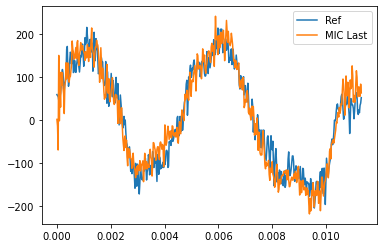

In [25]:
# Signal Generation
Angle = np.array([-60, 12, 70])#, -45, -5])#, 30, 45, 65])     # Impinging Angles
K = len(Angle)      #  Number of impinging signals

fs_rec, HSdata = sio.wavfile.read('./VoiceRecords/AugRecord.wav')
_, JPdata = sio.wavfile.read('./VoiceRecords/JuneRecord.wav')
HSdata = HSdata[:,0]
JPdata = JPdata[:,0]


data_i = np.zeros((K,100000))
data_i[0,:] = JPdata[160000:260000]   # 0.25 second signal
data_i[1,:] = HSdata[50000:150000]
#data_i[2,:] = HSdata[50000:150000]
data_i[2,:] = JPdata[60000:160000]
#data_i[3,:] = HSdata[125000:175000]
#data_i[4,:] = HSdata[170000:220000] 


# Add zero pad if sample length is odd
if len(data_i[0,:])%2!=0:
    data_i = np.pad(data_i,pad_width = ((0, 0), (0, 1)), constant_values=0)

Ns_true = len(data_i[0,:])    # Sample number 
fs_true = fs_rec   # Modeling frequency of real signals

t_true = np.arange(Ns_true)/fs_true
SigVec = np.zeros((K,Ns_true))

for i in range(K):
    SigVec[i,:] = (data_i[i,:])# - np.average(data_i[i,:]))


# Linear Arrays referenced at the edge of element (index = 0).
M = 3 # Antenna array count
vp = 340    # Propagation velocity in [m/s]
d_over_lamb = 0.5   # distance between element / wavelength
d = d_over_lamb*vp/(5e+3) # fmax is assumed to be 10 KHz

X = np.zeros((M,Ns_true))

## Convolutive Mixing using upsampling 
factor_ups = 10
for i in range(M):
    for j in range(K):
        X[i,:] += Tshift_Ups(SigVec[j,:], i*d*math.sin(Angle[j]*np.pi/180)/vp, fs_true, factor_ups)
        

Disp = 500


# Noise vector
SNR = 50  #[dB]
#np.random.seed(0)
SigMaxVar = np.max(np.var(SigVec,axis=1))/2
noiseVec =  np.random.normal(0,np.sqrt(SigMaxVar/(10**(SNR/10))),size=(M,len(SigVec[0,:])))    #Noise in time domain is real


X = X + noiseVec
plt.plot(t_true[:Disp],X[0,:Disp],label='Ref')
plt.plot(t_true[:Disp],X[K-1,:Disp],label = 'MIC Last')
plt.legend()
Audio(X[2,:], rate=fs_true)

In [192]:
Audio(SigVec[0,:], rate=samplerate)

In [26]:

############## Lowpass filter #############
X_LP = np.zeros((M,Ns_true))
f_cutoff = fs_true/4    # 8820 Hz
for i in range(M):
    X_LP[i,:] =  butter_lowpass_filter(X[i,:], f_cutoff, fs_true, 10)

############## Sampling #############
f_ADC = fs_true   # 8820 * 2 Hz
factor_ADC = int(fs_true/f_ADC)
X_ADC = X_LP[:,::factor_ADC]        # in time domain

for i in range(len(X_ADC[:,0])):
    X_ADC[i,:] = X_ADC[i,:]-np.average(X_ADC[i,:])

I = 200    # Number of snapshot(packet) to catch
Ns = 500   # Number of samples to take within a snapshot(packet)
t_ADC = np.arange(Ns*I)/f_ADC
############ Covariance Matrix generation    ###############
Rxx_f, Rxx_f_inv, Xs_f_tensor = Rxx_Gen_WB_t2f(X_ADC,I,Ns)          # input: time series, output: covariance matrix function of freq.

print("f_ADC:" ,f_ADC)
print(X_ADC.shape)
print(Rxx_f.shape)
print(Xs_f_tensor.shape)
# ##  Rxx_raw_try[:,:] = Xs_f[:,:] @ np.conjugate(Xs_f[:,:].T)    --- Check later for parallel method 

f_ADC: 44100
(3, 100000)
(3, 3, 500)
(3, 1, 200, 500)


In [27]:
print(Rxx_f_inv.shape)
print(Rxx_f.shape)

(3, 3, 500)
(3, 3, 500)


In [28]:
##### MVDR block for look direction ########

Angle_Tar= Angle
if Ns%2==0:
    freq_s = np.linspace(-f_ADC/2, f_ADC/2-f_ADC/Ns, Ns)
else:
    freq_s = np.linspace(-f_ADC/2 + 0.5*f_ADC/Ns, f_ADC/2-0.5*f_ADC/Ns, Ns)

print("Target Angles [deg]:",Angle_Tar)
SigVec_Tar = np.real(BF_MVDR_WB(Xs_f_tensor, Rxx_f,Rxx_f_inv, Angle_Tar, freq_s))          # MVDR weight and read


Target Angles [deg]: [-60  12  70]


In [29]:
Audio(np.real(SigVec_Tar[2,:]), rate=f_ADC)
#Audio(np.real(SigVec_Tar[1,:]), rate=f_ADC)

Pearson r of 0-th sig = 0.9162114667883168
Pearson r of 1-th sig = 0.9207506949286776
Pearson r of 2-th sig = 0.7932597236688116


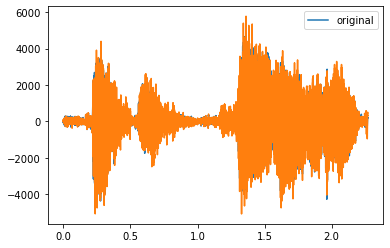

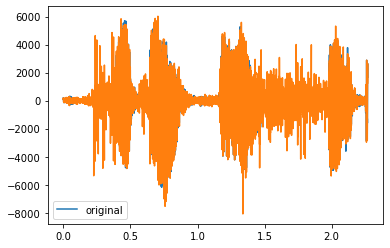

In [30]:
###### Evaluation of speech enhancement ######
plt.figure(0)
plt.plot(t_ADC,SigVec[0,::factor_ADC], label ='original')
plt.plot(t_ADC,SigVec_Tar[0,:])
plt.legend()
plt.figure(1)
plt.plot(t_ADC,SigVec[1,::factor_ADC], label='original')
plt.plot(t_ADC,SigVec_Tar[1,:])
plt.legend()
# Printing Pearson r
for i in range(K):
    print('Pearson r of %d-th sig =' %i, np.corrcoef(SigVec[i,::factor_ADC], SigVec_Tar[i,:])[1,0])



In [182]:
## Result comparison: GI only.


print(np.corrcoef(SigVec[0,:],SigVec_Tar[0,:]))
print(np.corrcoef(SigVec[1,:],SigVec_Tar[1,:]))
print(np.corrcoef(SigVec[2,:],SigVec_Tar[2,:]))

[[1.         0.91387605]
 [0.91387605 1.        ]]
[[1.         0.90768421]
 [0.90768421 1.        ]]
[[1.         0.78304853]
 [0.78304853 1.        ]]
